In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(8)

import numpy as np
import matplotlib.pyplot as plt

import candel

from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_median
import jax
from corner import corner


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data = candel.pvdata.load_SH0ES_separated("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")
q_names = data["q_names"]
data.keys()
# q_

2025-06-09 09:21:10 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-09 09:21:10 indices of zero width: [44]
2025-06-09 09:21:10 found zero-width prior at index 44. Setting it to 0.


dict_keys(['OH', 'logP', 'mag_cepheid', 'C_Cepheid', 'L_Cepheid', 'L_Cepheid_host_dist', 'L_SN_Cepheid_dist', 'L_SN_dist', 'C_SN_Cephed', 'Y_SN_Cepheid', 'L_SN_Cepheid', 'mu_N4258_anchor', 'e_mu_N4258_anchor', 'mu_LMC_anchor', 'e_mu_LMC_anchor', 'Y_SN', 'C_SN', 'L_SN', 'M_HST', 'e_M_HST', 'M_Gaia', 'e_M_Gaia', 'sigma_grnd', 'q_names', 'num_hosts', 'num_cepheids', 'num_flow_SN', 'czcmb_cepheid_host', 'e_czcmb_cepheid_host', 'RA_host', 'dec_host'])

In [6]:
m = data["czcmb_cepheid_host"] > 3300

data["e_czcmb_cepheid_host"][m] = 3000

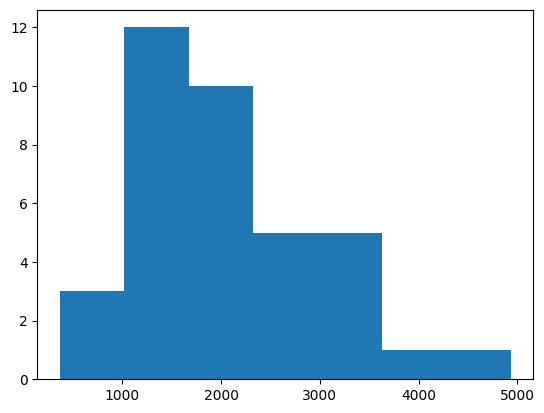

In [8]:
z = data["czcmb_cepheid_host"] #/ candel.SPEED_OF_LIGHT

plt.figure()
plt.hist(z, bins="auto")

plt.show()

In [10]:
model = candel.model.SH0ESModel(data)
kernel = NUTS(model, init_strategy=init_to_median(num_samples=5000))

mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=8)
mcmc.run(jax.random.PRNGKey(4), use_uniform_mu_priors=False)
mcmc.print_summary()


samples = mcmc.get_samples()

2025-06-09 09:30:23 Converting host RA/dec to Cartesian coordinates.
2025-06-09 09:30:23 set the following attributes: OH, logP, mag_cepheid, C_Cepheid, L_Cepheid, L_Cepheid_host_dist, L_SN_Cepheid_dist, L_SN_dist, C_SN_Cephed, Y_SN_Cepheid, L_SN_Cepheid, mu_N4258_anchor, e_mu_N4258_anchor, e2_mu_N4258_anchor, mu_LMC_anchor, e_mu_LMC_anchor, e2_mu_LMC_anchor, Y_SN, C_SN, L_SN, M_HST, e_M_HST, e2_M_HST, M_Gaia, e_M_Gaia, e2_M_Gaia, sigma_grnd, num_hosts, num_cepheids, num_flow_SN, czcmb_cepheid_host, e_czcmb_cepheid_host, e2_czcmb_cepheid_host, RA_host, dec_host, rhat_host


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]


                               mean       std    median      5.0%     95.0%     n_eff     r_hat
                       H0     67.40      1.69     67.39     64.56     70.11   4568.68      1.00
                      M_W     -5.92      0.02     -5.92     -5.96     -5.89   3353.84      1.00
                 Vext_mag    356.02     90.11    358.98    211.20    502.43   4575.35      1.00
                      Z_W     -0.19      0.06     -0.19     -0.28     -0.10   7686.17      1.00
                      b_W     -3.29      0.01     -3.29     -3.31     -3.26   8867.35      1.00
                      dZP     -0.01      0.04     -0.01     -0.07      0.05   4028.36      1.00
                   mu_LMC     18.48      0.03     18.48     18.43     18.52  10018.04      1.00
                   mu_M31     24.40      0.07     24.40     24.29     24.52   9390.98      1.00
                 mu_N4258     29.41      0.02     29.41     29.37     29.44   4990.04      1.00
               mu_host[0]     29.22    

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_63341/1691898437.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


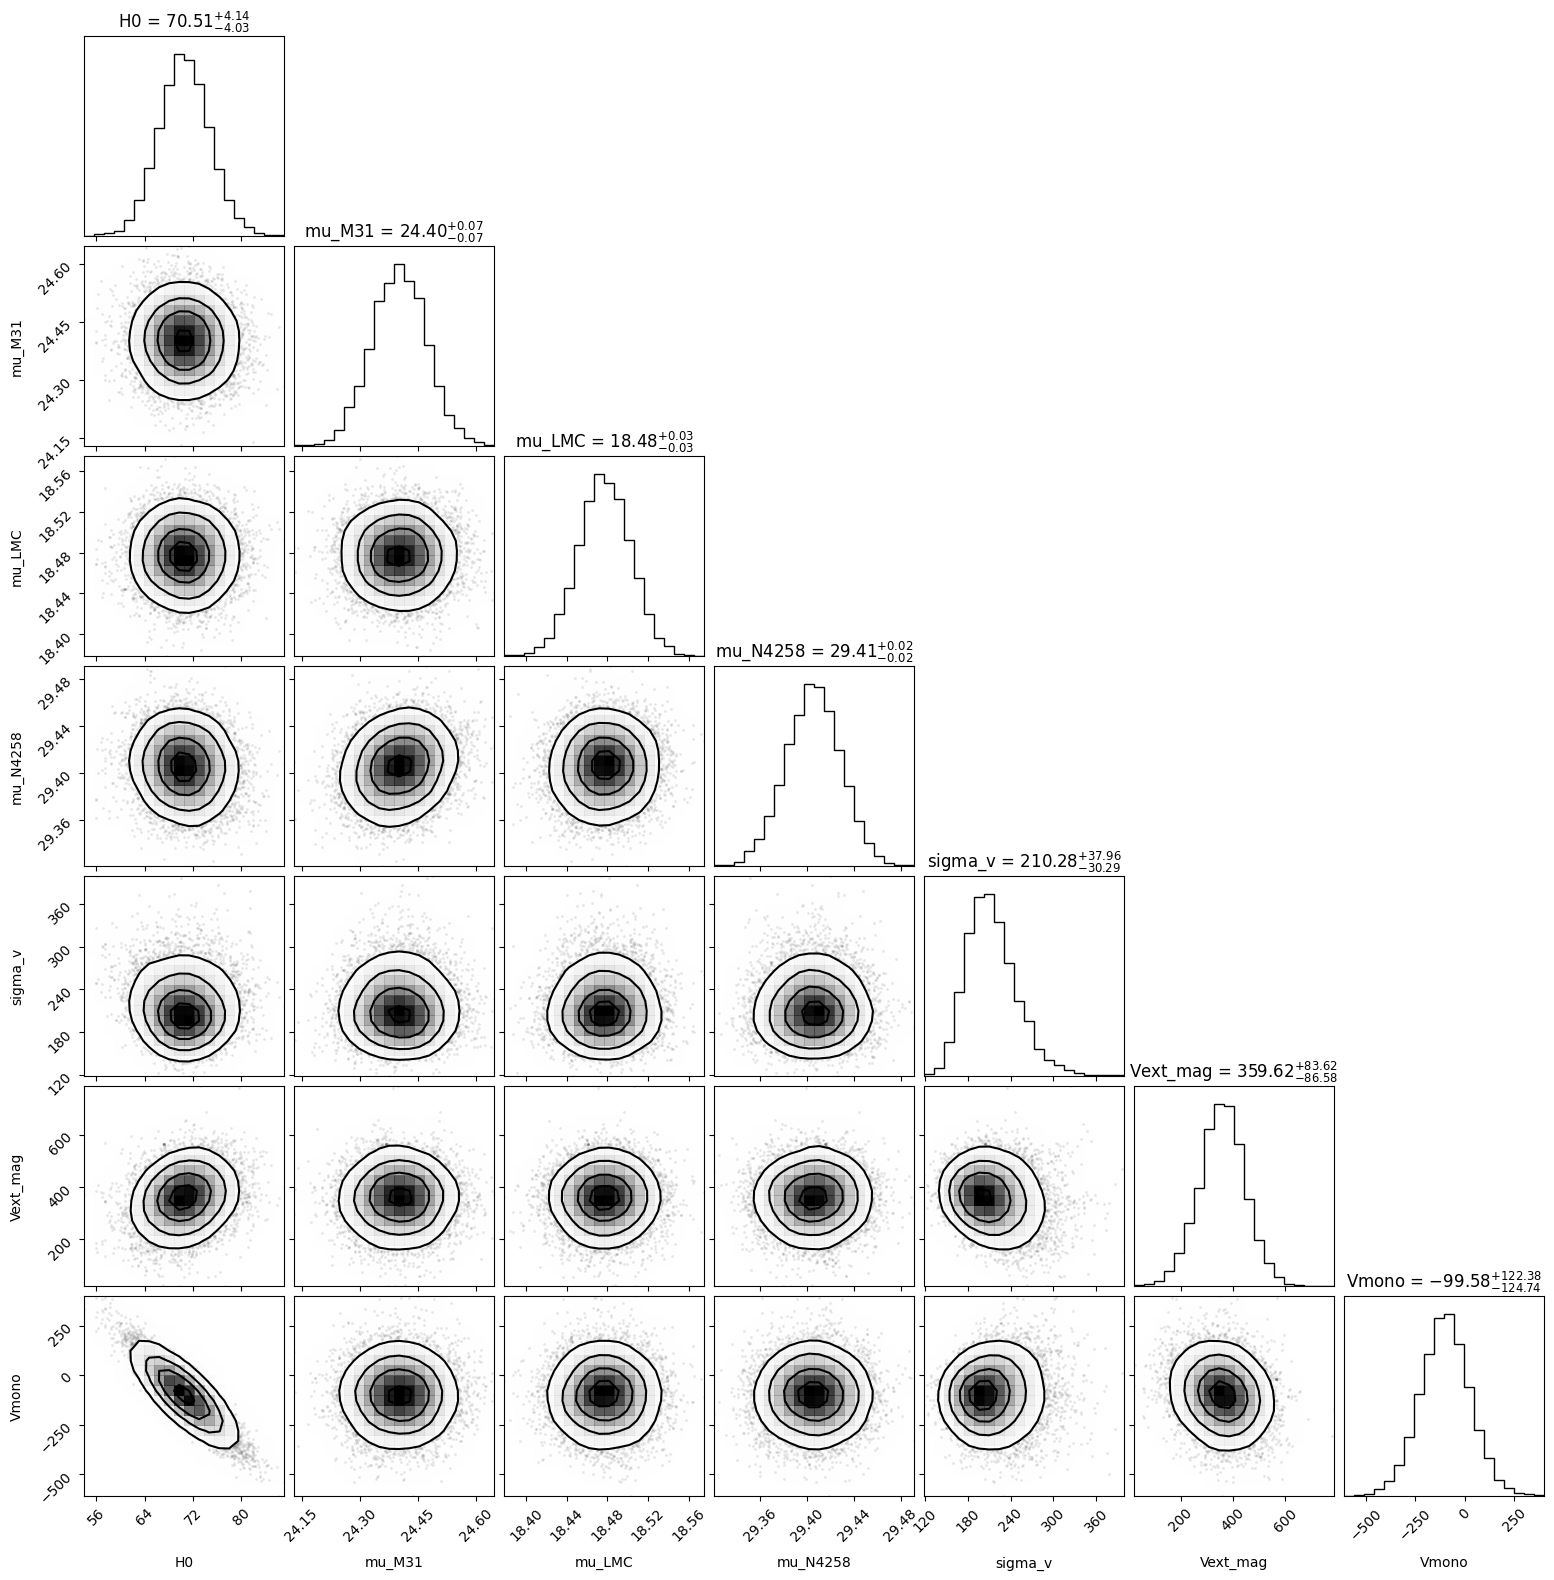

In [10]:
# Extract scalar parameter samples
# params = ["M_W", "Z_W", "b_W"]
# params = ["M_W", "Z_W", "b_W", "dZP",  "H0", "mu_M31", "mu_LMC", "mu_N4258", "sigma_v", "Vext_mag"]
params = ["H0", "mu_M31", "mu_LMC", "mu_N4258", "sigma_v", "Vext_mag", "Vmono"]
param_arrays = [samples[p] for p in params]

nmax = 4

# ks = list(range(nmax)) #+ [37, 38, 39]
ks = []

# Extract mu_host[0] to mu_host[7]
mu_host_subset = [samples["mu_host"][:, i] for i in ks]
# mu_host_subset = [samples["mu_host"][:, i] for i in [38, 39]]

# Concatenate all parameter samples
data_matrix = np.column_stack(param_arrays + mu_host_subset)

# Build label list
labels = params + [f"mu_host[{i}]" for i in ks]
# labels = params + [f"mu_host[{i}]" for i in [38, 39]]

# Generate the corner plot
fig = corner(data_matrix, labels=labels, show_titles=True, smooth=1)
fig.savefig("corner_plot.png", dpi=300)
fig.show()

In [ ]:
from scipy.stats import norm
import posterior_agreement

H0_SH0ES = samples["H0"]
H0_planck = norm(67.4, 0.5).rvs(50000)



chains = (H0_SH0ES, H0_planck)
agreement_1d = posterior_agreement.compute_agreement(chains)

print("p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

In [ ]:
samples["mu_host"].max()

In [ ]:
H0=(67.4±0.5)km/s

In [ ]:
# Before 2150 are the Cepihed hosts without geometric anchors
# At 2150 Start the N4258 hosts
# At 2593 Start the M31 hosts
# At 2648 start the LMC hosts
# At index 3130 start having supernovae in Cepheid hosts

# Between 3130 and 3207 are the rung two supernovae

# 3207 is the sigma_HST
# 3208 is sigma_Gaia
# 3209 is ? looks like some prior on Z_W
# 3210 is some bullshit that is never used
# 3211 is the sigma_grnd
# 3212 looks like some prior on b_W
# 3213 is the constraint on delta_mu_N4258
# 3214 is the constraint on delta_mu_LMC

# At 3215 and onwards are the Hubble flow supernovae

[3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214]





In [ ]:
data = candel.pvdata.load_SH0ES("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")
Y = np.array(data["Y"], copy=True)
C = np.array(data["C"], copy=True)
L = np.array(data["L"], copy=True).T

# q_names = data["q_names"]

In [ ]:
k = 2647


print(f"Y[{k}] = {Y[k]}")
print(f"C[{k}, {k}] = {C[k, k]}")
print(f"L[{k}, :] = {L[k, :]}")


q_names[L[k, :] != 0.0]